In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv("cleaned_data.csv", low_memory=False)

# Display the first few rows
df.head()

,loan_amnt,emp_length,title,dti
0,3600.0,10.0,Debt consolidation,5.91
1,24700.0,10.0,Business,16.06
2,20000.0,10.0,NaN,10.78
3,35000.0,10.0,Debt consolidation,17.06
4,10400.0,3.0,Major purchase,25.37


In [42]:
#df = df[df['is_default'].notnull()]
features = ['loan_amnt','emp_length','dti']
print(df[features].isnull().sum())


loan_amnt         33
emp_length    146940
dti             1744
dtype: int64


for col in features:
    df[f'{col}_missing'] = df[col].isnull().astype(int)

This code may be used later to flag unites that have missing values before the values are mutated to add an aditional feature for pattern recognition. Maybe the missing data tells us more than if it were there. 


In [45]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='median')

X = imputer.fit_transform(df[features])
y = df['is_default'].values


KeyError: 'is_default'

In [10]:
print(type(X))  # Confirm it's a NumPy array
print(X.shape)  # Check dimensions (rows, columns)
print(X[:5])    # Preview first 5 rows


<class 'numpy.ndarray'>
(1348099, 5)
[[1.39900e+01 6.75000e+02 5.50000e+04 3.60000e+03 5.91000e+00]
 [1.19900e+01 7.15000e+02 6.50000e+04 2.47000e+04 1.60600e+01]
 [1.07800e+01 6.95000e+02 6.30000e+04 2.00000e+04 1.07800e+01]
 [2.24500e+01 6.95000e+02 1.04433e+05 1.04000e+04 2.53700e+01]
 [1.34400e+01 6.90000e+02 3.40000e+04 1.19500e+04 1.02000e+01]]


In [12]:
X_df = pd.DataFrame(X, columns=features)
print(X_df.head())  # Check the first few rows


   int_rate  fico_range_low  annual_inc  loan_amnt    dti
0     13.99           675.0     55000.0     3600.0   5.91
1     11.99           715.0     65000.0    24700.0  16.06
2     10.78           695.0     63000.0    20000.0  10.78
3     22.45           695.0    104433.0    10400.0  25.37
4     13.44           690.0     34000.0    11950.0  10.20


In [14]:
print(X_df.isnull().sum())  # Should all be zero


int_rate          0
fico_range_low    0
annual_inc        0
loan_amnt         0
dti               0
dtype: int64


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.81      0.99      0.89    323622
           1       0.50      0.06      0.10     80808

    accuracy                           0.80    404430
   macro avg       0.65      0.52      0.49    404430
weighted avg       0.74      0.80      0.73    404430

ROC AUC: 0.692173545375545


So, not too good. It is good at predicting nondefault but terrible at predicting defaults. This is most likely due to the inbalance in the class distribution.
Now I will balance the class. 

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.87      0.66      0.75    323622
           1       0.31      0.61      0.41     80808

    accuracy                           0.65    404430
   macro avg       0.59      0.64      0.58    404430
weighted avg       0.76      0.65      0.68    404430

ROC AUC: 0.6919548914393594


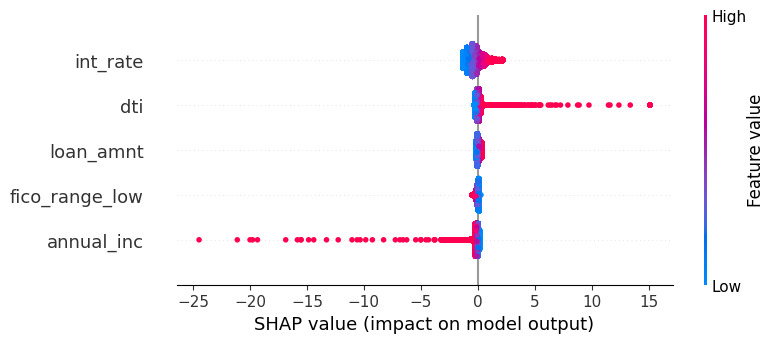

In [25]:
import shap

explainer = shap.Explainer(model, X_resampled, feature_names=X_df.columns)
shap_values = explainer(X_test)

# Summary plot
shap.plots.beeswarm(shap_values)


Below is the report for the first bower in the dataset, id=0.

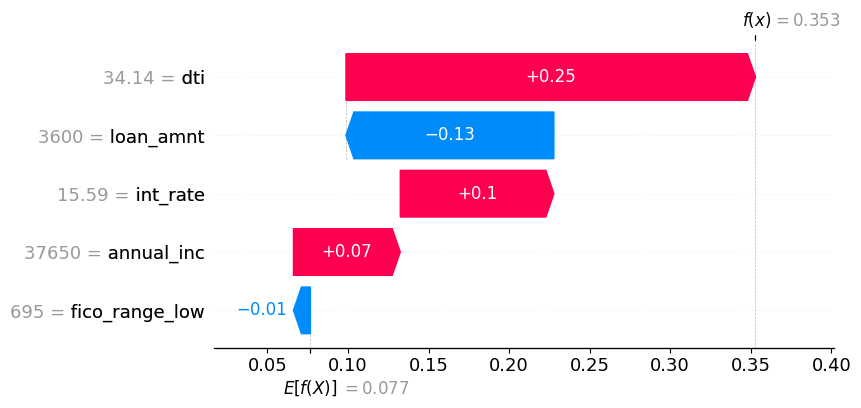

In [28]:
shap.plots.waterfall(shap_values[0])


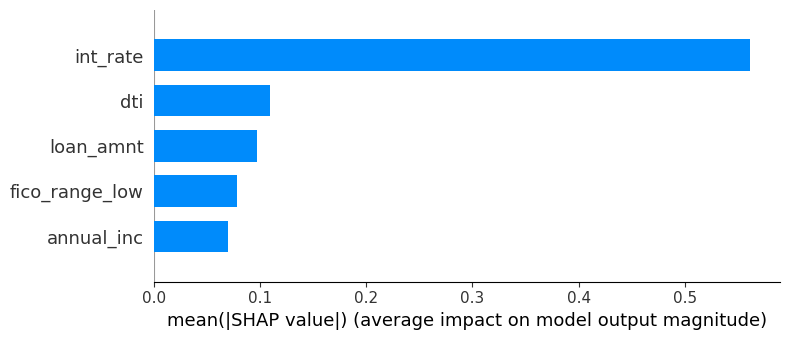

In [30]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [34]:
print(X_resampled)

[[6.62000000e+00 7.55000000e+02 1.00000000e+05 1.80000000e+04
  1.13300000e+01]
 [1.34800000e+01 6.85000000e+02 7.87000000e+04 1.40000000e+04
  1.06000000e+01]
 [1.61400000e+01 6.75000000e+02 8.00000000e+04 1.00000000e+04
  1.44500000e+01]
 ...
 [1.23549835e+01 7.17500330e+02 3.20000000e+04 4.20000000e+03
  1.06449394e+01]
 [1.39672807e+01 7.00000000e+02 6.08355758e+04 1.28644242e+04
  1.93523094e+01]
 [1.03833786e+01 6.65000000e+02 9.50000000e+04 2.50000000e+04
  2.48586727e+01]]


In [5]:
approved_df = pd.read_csv("approved_df_matched")
unapproved_df = pd.read_csv("unapproved_df_matched")

In [7]:
print(unapproved_df)

               id  loan_amnt  emp_length  loan_status               title  \
0        68407277     3600.0        10.0   fully paid  Debt consolidation   
1        68355089    24700.0        10.0   fully paid            Business   
2        68341763    20000.0        10.0   fully paid                 NaN   
3        68476807    10400.0         3.0   fully paid      Major purchase   
4        68426831    11950.0         4.0   fully paid  Debt consolidation   
...           ...        ...         ...          ...                 ...   
1348094  89905081    18000.0         5.0   fully paid    Home improvement   
1348095  88948836    29400.0         9.0   fully paid  Debt consolidation   
1348096  89996426    32000.0         3.0  charged off    Home improvement   
1348097  90006534    16000.0        10.0   fully paid    Medical expenses   
1348098  88224441    24000.0         6.0  charged off  Debt consolidation   

           dti  is_default  
0         5.91           0  
1        16.06   

##Semi-Supervised Learning

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

features = ['loan_amnt', 'dti', 'emp_length']

# Prepare your approved (labeled) and unapproved (unlabeled) datasets
X_labeled = approved_df[features]  # your chosen features
y_labeled = approved_df['is_default']    # 0 or 1 for default

X_unlabeled = unapproved_df[features]
y_unlabeled = [-1] * len(X_unlabeled)  # unlabeled data must be marked as -1

# Combine them
X_combined = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_combined = pd.Series(list(y_labeled) + y_unlabeled)

# Fill missing values in features with the mean
imputer = SimpleImputer(strategy='mean')
X_combined = imputer.fit_transform(X_combined)

# Optional: scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Semi-supervised learning
base_model = LogisticRegression(max_iter=1000)
self_training_model = SelfTrainingClassifier(base_model, criterion='k_best')

# Train
self_training_model.fit(X_scaled, y_combined)

# Predict on unapproved data
unapproved_preds = self_training_model.predict(X_scaled[len(X_labeled):])


Prediction distribution on unapproved data:
Label 0: 27467480 predictions
Label 1: 181261 predictions


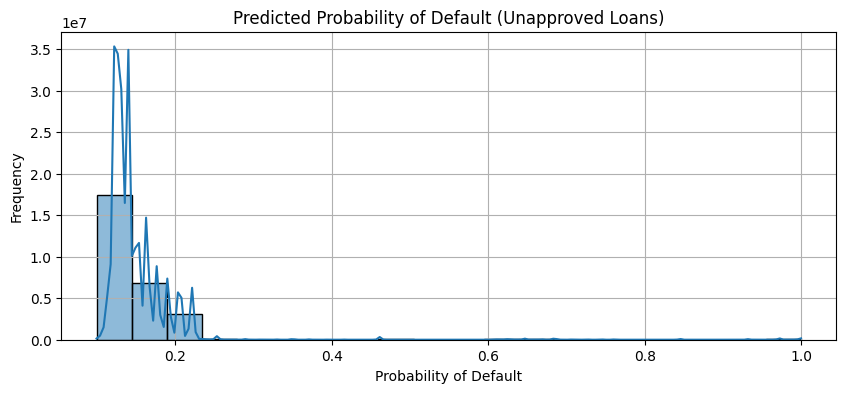

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Recalculate predictions
X_unlabeled_scaled = X_scaled[len(X_labeled):]  # only unlabeled part
unapproved_preds = self_training_model.predict(X_unlabeled_scaled)
unapproved_probs = self_training_model.predict_proba(X_unlabeled_scaled)[:, 1]

# Summary of predictions
print("Prediction distribution on unapproved data:")
unique, counts = np.unique(unapproved_preds, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} predictions")

# Optional: visualize prediction probabilities
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(unapproved_probs, bins=20, kde=True)
plt.title("Predicted Probability of Default (Unapproved Loans)")
plt.xlabel("Probability of Default")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [21]:
unapproved_df['predicted_default'] = unapproved_preds
unapproved_df['predicted_probability'] = unapproved_probs

In [41]:
unapproved_df['predicted_default'].value_counts(normalize=True) * 100

predicted_default
0    99.344415
1     0.655585
Name: proportion, dtype: float64

##Propensity Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Use fewer features temporarily
quick_features = ['loan_amnt', 'dti', 'emp_length']  # example subset

X = combined_df[quick_features]
y = combined_df['approved']

# Fill missing values simply (for test purposes)
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

model = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42)  # smaller forest
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=20, random_state=42)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[5517906   11842]
 [  12078  257542]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5529748
           1       0.96      0.96      0.96    269620

    accuracy                           1.00   5799368
   macro avg       0.98      0.98      0.98   5799368
weighted avg       1.00      1.00      1.00   5799368

ROC AUC Score: 0.998256063754907


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Create a dataset combining approved and unapproved
approved_df['approved'] = 1
unapproved_df['approved'] = 0

combined_df = pd.concat([approved_df, unapproved_df], ignore_index=True)

# Define features and label
X = combined_df[features]  # Make sure both datasets have the same columns
y = combined_df['approved']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# Train propensity model
propensity_model = RandomForestClassifier(n_estimators=100, random_state=42)
propensity_model.fit(X_train, y_train)

# Evaluate
y_pred_proba = propensity_model.predict_proba(X_test)[:, 1]
print("Propensity model AUC:", roc_auc_score(y_test, y_pred_proba))

# Get scores for all data
combined_df['propensity_score'] = propensity_model.predict_proba(X)[:, 1]